# Data Science project 3, Web Server Access Logs

## ML6, Integrify

### Hannu Kiiskinen, 22.11.2023

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime, timedelta
from scipy.stats import chi2_contingency
from scipy.stats import f, f_oneway
from sklearn import preprocessing
from wordcloud import WordCloud, STOPWORDS

## Descriptive statistics

### Dataset

Web Server Access Logs from Kaggle. Data collected 3 years ago.

Web sever logs contain information on any event that was registered/logged. This contains a lot of insights on website visitors, behavior, crawlers accessing the site, business insights, security issues, and more. 3.3GB of logs from an Iranian ecommerce website zanbil.ir.

License: CC0, Public Domain

In [2]:
# All the columns
df = pd.read_csv("DS_Project3/access.log", sep=" ", header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10
0,54.36.149.41,-,-,[22/Jan/2019:03:56:14,+0330],GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,-
1,31.56.96.51,-,-,[22/Jan/2019:03:56:16,+0330],GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
2,31.56.96.51,-,-,[22/Jan/2019:03:56:16,+0330],GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-


In [4]:
# Renaming and filtering the useful columns
df.columns = ["ip_address", "Col2", "Col3", "date", "Col5", "call", "http_status", "size", "pages", "browser", "Col11"]
df1 = df.filter(items=['ip_address', 'date', 'call', 'http_status', 'size', 'pages', 'browser'])
df1.head(3)

,ip_address,date,call,http_status,size,pages,browser
0,54.36.149.41,[22/Jan/2019:03:56:14,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,[22/Jan/2019:03:56:16,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,[22/Jan/2019:03:56:16,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...


In [5]:
# Parsing the date format
daynmonth = df1['date'].str[1:12].str.strip()
time = df1['date'].str[13:22].str.strip()
df1['date'] = daynmonth + ' ' + time
df1['date'] = pd.to_datetime(df1['date'])
df1.head(3)

,ip_address,date,call,http_status,size,pages,browser
0,54.36.149.41,2019-01-22 03:56:14,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...


## Data review

10365152 entries, 7 columns, two float, one datetime and rest object data types.

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10365152 entries, 0 to 10365151
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ip_address   object        
 1   date         datetime64[ns]
 2   call         object        
 3   http_status  int64         
 4   size         int64         
 5   pages        object        
 6   browser      object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 553.6+ MB


### Distribution of data

In [8]:
df2 = df1.filter(items=['size'])
df2.describe()

,size
count,1.036515e+07
mean,1.243311e+04
std,2.812654e+04
min,0.000000e+00
25%,2.027000e+03
50%,4.120000e+03
75%,1.155100e+04
max,1.249490e+06


In [9]:
# Show unique values

df1.nunique()

ip_address     258606
date           400109
call           894210
http_status        16
size            69707
pages          103237
browser         28343
dtype: int64

In [10]:
# Show value counts of selected columns

df1.ip_address.value_counts(), df1.http_status.value_counts(), df1.date.value_counts()

(66.249.66.194      353483
 66.249.66.91       314522
 151.239.241.163     92475
 66.249.66.92        88332
 91.99.30.32         45979
                     ...  
 95.162.203.136          1
 89.196.19.215           1
 83.120.212.104          1
 5.113.178.207           1
 89.199.68.13            1
 Name: ip_address, Length: 258606, dtype: int64,
 200    9579825
 304     340228
 302     199835
 404     105011
 301      67553
 499      50852
 500      14266
 403       5634
 502        798
 400        586
 401        323
 408        112
 504        103
 414         17
 405          6
 206          3
 Name: http_status, dtype: int64,
 2019-01-26 19:07:39    368
 2019-01-26 19:05:58    323
 2019-01-26 16:06:25    313
 2019-01-26 12:39:19    309
 2019-01-26 09:59:47    298
                       ... 
 2019-01-24 04:24:32      1
 2019-01-26 02:46:19      1
 2019-01-26 09:05:16      1
 2019-01-25 07:04:49      1
 2019-01-25 06:29:45      1
 Name: date, Length: 400109, dtype: int64)

### Factors (meaning of the columns)

A web server’s access log file contains detailed information about each request made to the server. While it’s possible to format the log entries to include certain information about each request, access logs typically list details such as:

- What files were requested – HTML, images, other website content, etc.
- Request type, such as GET, POST, etc.
- What kind of device and browser made the request
- Which pages users, crawlers, and bots are viewing
- The IP address of the computer or device making the request
- HTTP status codes showing the results of each request
    - Informational responses (100 – 199)
    - Successful responses (200 – 299)
    - Redirection messages (300 – 399)
    - Client error responses (400 – 499)
    - Server error responses (500 – 599)
- Loaded file size

### Relationship of features

Looking the feature relationship by using visualization

In [11]:
# Filter Factors
df2 = df1.filter(items=['date', 'size'])
df2 = df2.set_index('date')
df2 = df2.iloc[0:15]

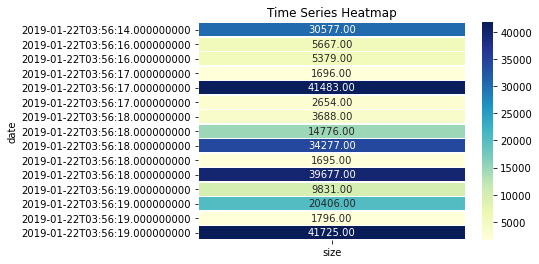

In [12]:
# Create a time series heatmap
sns.heatmap(df2, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title("Time Series Heatmap")
plt.show()

## Explotary Data Analysis

### Clean the data

- There are some missing values but the amount is so small compared the all dataset that these can be dropped
- Outliers shown in BoxPlot

In [13]:
# Check missing values

df1.isna().sum()

ip_address      0
date            0
call            6
http_status     0
size            0
pages          20
browser         7
dtype: int64

In [16]:
# Drop nan-values

df1 = df1.dropna()
df.shape[0], df1.shape[0]

(10365152, 10365119)

<AxesSubplot:>

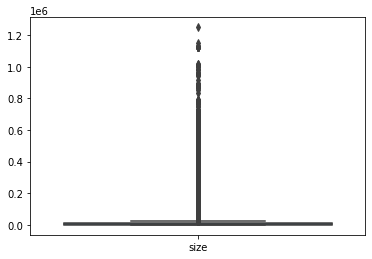

In [21]:
df2 = df1.filter(items=['size'])
sns.boxplot(data=df2)

### Transformation

- Date was transfered to datetime-format already earlier 

### Data visualization

<AxesSubplot:xlabel='date', ylabel='res_time'>

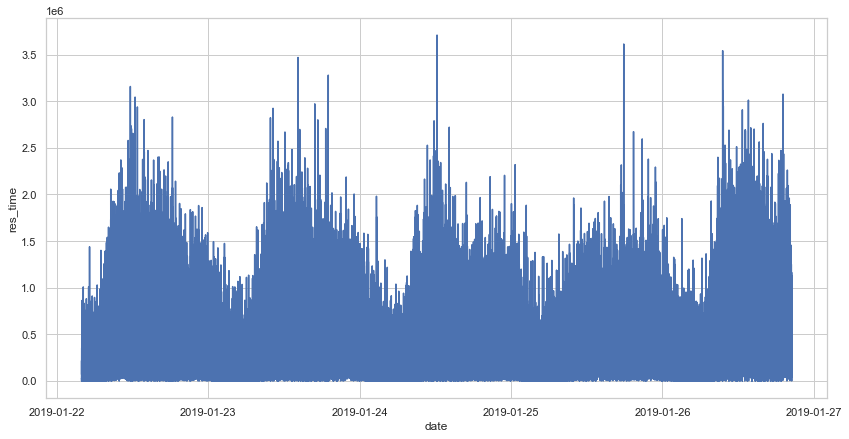

In [108]:
# Plot the history of Server response sum in timeline
df_draw = df1.groupby(['date']).sum().sort_values(by=['date'], ascending=True)
df_draw = df_draw.filter(items=['date', 'res_time'])
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_draw, x="date", y="res_time")

In [22]:
# Check the Highest request result status codes
df_codes = df1.groupby(['http_status']).sum().sort_values(by=['size'], ascending=False)

In [23]:
df_codes

,size
http_status,
200,126723695149
404,1672806699
500,460921757
301,10949369
403,894398
502,334546
401,307173
206,202900
400,121172


### Top three IP-addresses:

- 40.77.167.13, Microsoft corp, US, Virginia, Boydton
- 207.46.13.199, Microsoft corp, US, Washington, Quincy
- 37.254.0.202, Telecommunication Company of Esfahan, Iran, Esfahan, Kashan

In [24]:
# Top ip-address using server
df_draw = df1.sort_values(['size'],ascending=False).groupby('ip_address').head(3)
df_draw

,ip_address,date,call,http_status,size,pages,browser
181244,40.77.167.13,2019-01-22 08:54:13,GET /image/5795?name=lg_13541539..3.png&wh=max...,200,1249490,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
641248,207.46.13.199,2019-01-22 11:56:57,GET /image/5883?name=lg_1.....png&wh=max HTTP/1.1,200,1147355,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
1240629,37.254.0.202,2019-01-22 15:49:17,GET /image/5801?name=er217%2C%2C%2C....png&wh=...,200,1126965,https://www.zanbil.ir/m/product/5801/6386/%D9%...,Mozilla/5.0 (Linux; Android 6.0.1; Lenovo TB2-...
8075860,85.133.194.178,2019-01-25 22:55:36,GET /image/5801?name=er217%2C%2C%2C....png&wh=...,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...
149280,185.180.53.254,2019-01-22 08:35:53,GET /image/5801?name=er217%2C%2C%2C....png&wh=...,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 6.1; rv:45.0) Gecko/20...
...,...,...,...,...,...,...,...
4088160,37.148.65.71,2019-01-23 20:22:19,GET /image/419?name=1200.jpg&wh=max HTTP/1.1,200,0,https://www.google.com/,Mozilla/5.0 (Linux; Android 8.0.0; SM-A810F Bu...
4088155,5.125.100.126,2019-01-23 20:22:18,GET /image/769/mainSlide HTTP/1.1,200,0,-,Mozilla/5.0 (Linux; U; Android 4.3; fa-ir; G63...
4088192,5.123.117.161,2019-01-23 20:22:19,GET /image/33888?name=model-b2048u-1-.jpg&wh=2...,200,0,-,Dalvik/2.1.0 (Linux; U; Android 8.0.0; SM-G570...
4088200,172.80.204.116,2019-01-23 20:22:20,GET /image/33888?name=model-b2048u-1-.jpg&wh=2...,200,0,-,Dalvik/2.1.0 (Linux; U; Android 8.1.0; SM-G610...


In [16]:
# Split the data in call-column
df3 = pd.DataFrame(df1.call.str.split('/',3).tolist(), columns = ['call1','call2','call3','call4'])

In [18]:
# Top three calls
calls = df3.call2.value_counts()
calls[0:3]

image     5682832
static    2000255
m          555154
Name: call2, dtype: int64

In [35]:
# Split the data in browser-column
df4 = pd.DataFrame(df1.browser.str.split('/',2).tolist(), columns = ['browser1','browser2','browser3'])

# Top three Browsers
browsers = df4.browser1.value_counts()
browsers[0:3]

Mozilla            9873760
Dalvik              209716
Googlebot-Image     159118
Name: browser1, dtype: int64

## Research question 1

Does the error calls make a difference to Loaded file size. All succesful loads (code=200) are ignored.

### Is there a relationship between Loaded file size and HTTP-status?

#### Hypothesis definition

H0: There are no significant association between Loaded file size and HTTP-status

H1: There are significant association between Loaded file size and HTTP-status

In [25]:
# Data to be used
df_codes_mu = df1.groupby(['http_status']).mean().sort_values(by=['size'], ascending=False)

In [26]:
# Data to be used
df_codes_test = df_codes_mu[1:11]
df_codes_test

,size
http_status,
500,32309.109561
404,15929.823533
200,13228.220670
405,977.000000
401,951.000000
504,570.000000
502,419.230576
400,208.917241
414,186.000000


### Test selection

As the data is Categorial, Chi-square test will be used.

In [28]:
# Using Chi-square test, test the hypothesis
stat, p, dof, expected = chi2_contingency(df_codes_test)

# interpret p-value
alpha = 0.05
print(f"\nChi_S-value: {round(stat, 1)}, Significance Level (alpha): {alpha}, p-value: {round(p, 2)}")

if p <= alpha:
    print('Reject H0, There are no significant association between Loaded file size and HTTP-status.')
else:
    print('Accept H0, There are significant association between Loaded file size and HTTP-status.')


Chi_S-value: 0.0, Significance Level (alpha): 0.05, p-value: 1.0
Accept H0, There are significant association between Loaded file size and HTTP-status.


### Result of test

As test will show, there are significant association between Server Response time and HTTP-status.

## Research question 2

Does the Call type make any difference to Loaded file size.

### Is there a relationship between Call type and Loaded file size?

#### Hypothesis definition

H0: There are no significant association between Call type and Loaded file size

H1: There are significant association between Call type and Loaded file size

In [17]:
# Data
df_eva1 = pd.merge(df1, df3, left_index=True, right_index=True)

In [18]:
df_eva2 = df_eva1.loc[(df_eva1['call2'] == 'image') | (df_eva1['call2'] == 'static') | (df_eva1['call2'] == 'm') | (df_eva1['call2'] == 'settings') | (df_eva1['call2'] == 'filter')]
df_eva2

,ip_address,date,call,http_status,res_time,pages,browser,call1,call2,call3,call4
0,54.36.149.41,2019-01-22 03:56:14,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,GET,filter,27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D...,1.1
1,31.56.96.51,2019-01-22 03:56:16,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,GET,image,60844,productModel/200x200 HTTP/1.1
2,31.56.96.51,2019-01-22 03:56:16,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,GET,image,61474,productModel/200x200 HTTP/1.1
3,40.77.167.129,2019-01-22 03:56:17,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,GET,image,14925,productModel/100x100 HTTP/1.1
5,40.77.167.129,2019-01-22 03:56:17,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,GET,image,23488,productModel/150x150 HTTP/1.1
...,...,...,...,...,...,...,...,...,...,...,...
10365111,180.94.84.225,2019-01-26 20:29:12,GET /settings/logo HTTP/1.1,200,4120,https://www.zanbil.ir/m/article/616/%D8%B9%D9%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,GET,static,images,amp/telegram.png HTTP/1.1
10365112,5.120.63.25,2019-01-26 20:29:12,GET /m/browse/stove-and-oven HTTP/1.1,200,19059,https://www.zanbil.ir/m/filter/b151%2Cp4,Mozilla/5.0 (Linux; Android 4.3; C5303 Build/1...,GET,static,images,amp/blog.png HTTP/1.1
10365113,151.241.254.118,2019-01-26 20:29:12,GET /image/1221/mainSlide HTTP/1.1,200,90490,https://www.zanbil.ir/filter/b80,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,GET,static,images,amp/third-party/footer-mobile.png HTTP/1.1
10365116,5.120.204.67,2019-01-26 20:29:12,GET /settings/logo HTTP/1.1,200,4120,https://www.zanbil.ir/m/browse/food-processor/...,Mozilla/5.0 (Linux; Android 5.0.2; SM-A500H Bu...,GET,m,product,18962/%D8%BA%D8%B0%D8%A7-%D8%B3%D8%A7%D8%B2-%D...


In [30]:
# label_encoder object knows  
# how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'call2'. 
df_eva2['call2']= label_encoder.fit_transform(df_eva2['call2'])

<ipython-input-30-314242931873>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eva2['call2']= label_encoder.fit_transform(df_eva2['call2'])


In [31]:
df_eva2['call2'].unique()

array([0, 1, 2, 3, 4])

In [32]:
# Data
df_eva3 = df_eva2[['call2']]['call2']
df_eva4 = df_eva2[['res_time']]['res_time']

In [33]:
# Using Anova-test do test between different Calls
F_Stat, p_value = stats.f_oneway(df_eva3, df_eva4)
#F_Stat = F_Stat
#p_value = p_value

# interpret p-value
alpha = 0.05

print(f'\nF_statistics: {F_Stat}, P_value: {p_value}, alpha: {alpha}\n')

if p_value < alpha:
    print('Reject H0, There is at-least one Call which has different mean!')
else:
    print('Accept H0, all the Call have equal means!')


F_statistics: 1807848.5708299729, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Call which has different mean!


## Research question 3

Does the browser make any difference to Loaded file size.

### Is there a relationship between Loaded file size and Browser?

#### Hypothesis definition

H0: There are no significant association between Loaded file size and Browser

H1: There are significant association between Loaded file size and Browser

In [36]:
# Data
df_eva5 = pd.merge(df1, df4, left_index=True, right_index=True)
df_eva5

,ip_address,date,call,http_status,res_time,pages,browser,browser1,browser2,browser3
0,54.36.149.41,2019-01-22 03:56:14,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,Mozilla,5.0 (compatible; AhrefsBot,6.1; +http://ahrefs.com/robot/)
1,31.56.96.51,2019-01-22 03:56:16,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,Mozilla,5.0 (Linux; Android 6.0; ALE-L21 Build,"HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like..."
2,31.56.96.51,2019-01-22 03:56:16,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,Mozilla,5.0 (Linux; Android 6.0; ALE-L21 Build,"HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like..."
3,40.77.167.129,2019-01-22 03:56:17,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,Mozilla,5.0 (compatible; bingbot,2.0; +http://www.bing.com/bingbot.htm)
4,91.99.72.15,2019-01-22 03:56:17,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,Mozilla,5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko,16.0 Firefox/16.0
...,...,...,...,...,...,...,...,...,...,...
10365114,151.241.254.118,2019-01-26 20:29:12,GET /image/8864/specialSale HTTP/1.1,200,36415,https://www.zanbil.ir/filter/b80,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,Mozilla,5.0 (Linux; Android 7.0; SM-N920C Build,"NRD90M) AppleWebKit/537.36 (KHTML, like Gecko)..."
10365115,151.241.254.118,2019-01-26 20:29:12,GET /image/1226/mainSlide HTTP/1.1,200,100979,https://www.zanbil.ir/filter/b80,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,MobileSafari,604.1 CFNetwork,976 Darwin/18.2.0
10365116,5.120.204.67,2019-01-26 20:29:12,GET /settings/logo HTTP/1.1,200,4120,https://www.zanbil.ir/m/browse/food-processor/...,Mozilla/5.0 (Linux; Android 5.0.2; SM-A500H Bu...,Mozilla,5.0 (iPhone; CPU iPhone OS 10_2_1 like Mac OS ...,"602.4.6 (KHTML, like Gecko) Version/10.0 Mobil..."
10365117,5.127.220.71,2019-01-26 20:29:12,GET /favicon.ico HTTP/1.1,200,0,-,MobileSafari/604.1 CFNetwork/976 Darwin/18.2.0,Mozilla,5.0 (Windows NT 6.1; rv:64.0) Gecko,20100101 Firefox/64.0


In [37]:
df_eva6 = df_eva5.loc[(df_eva5['browser1'] == 'Mozilla') | (df_eva5['browser1'] == 'Dalvik') | (df_eva5['browser1'] == 'Googlebot-Image') | (df_eva5['browser1'] == 'MobileSafari')]

In [38]:
# Encode labels in column 'browser1'. 
df_eva6['browser1']= label_encoder.fit_transform(df_eva6['browser1'])
df_eva6['browser1'].unique()

<ipython-input-38-841d81955eea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eva6['browser1']= label_encoder.fit_transform(df_eva6['browser1'])


array([3, 1, 0, 2])

In [39]:
# Data
df_eva7 = df_eva6[['browser1']]['browser1']
df_eva8 = df_eva6[['res_time']]['res_time']

In [40]:
# Using Anova-test do test between different Browsers
F_Stat, p_value = stats.f_oneway(df_eva7, df_eva8)
#F_Stat = F_Stat
#p_value = p_value

# interpret p-value
alpha = 0.05

print(f'\nF_statistics: {F_Stat}, P_value: {p_value}, alpha: {alpha}\n')

if p_value < alpha:
    print('Reject H0, There is at-least one Browser which has different mean!')
else:
    print('Accept H0, all the Browsers have equal means!')


F_statistics: 2026714.050416967, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Browser which has different mean!


## Make wordcloud for last column which haven't been used yet

In [41]:
words = df1.pages[0:500000]

In [42]:
# Create stopword list:
stopwords = set(STOPWORDS)

lst = []
for i in range(10):
    lst.append('A' + str(i))
    lst.append('B' + str(i))
    lst.append('D' + str(i))

lst = ["https", "m", "filter", "8C", "AA", "AC", "AD", "AE", "AF", "DA", "DB", "browse", "bundle", "bundle_site_head"] + lst
    
stopwords.update(lst)

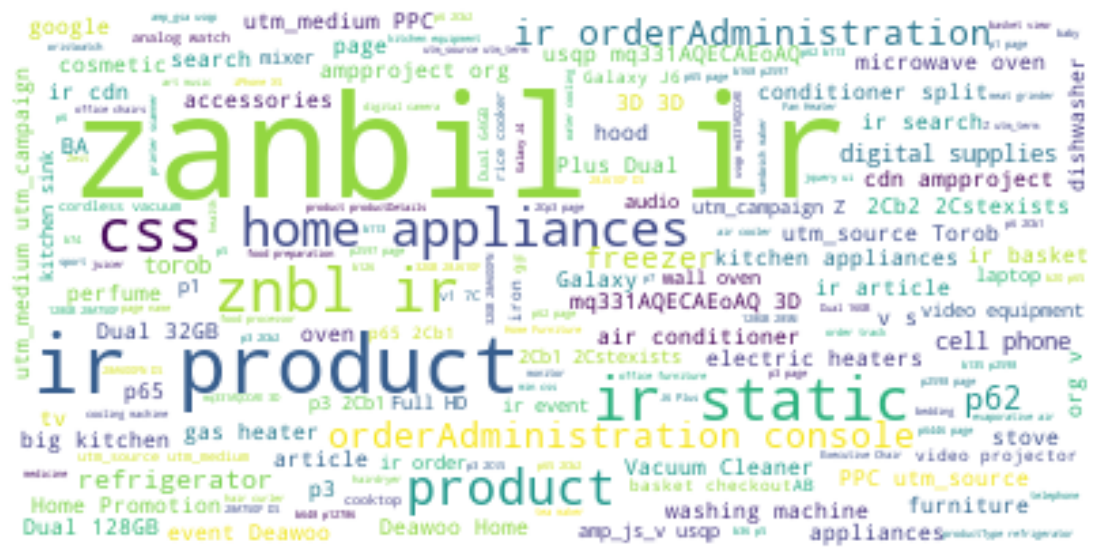

In [43]:
# Create a word cloud
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(words))

# Display the word cloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()